In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools 
import random
import numpy as np
import matplotlib.lines as mlines
import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
def load_file(f):
    with open(f, "rb") as rb:
        pickle.load(rb)
        #return pickle.load(rb)
        return CPU_Unpickler(rb).load()

In [2]:
def choice_lr(net,s,s0,L):
    if net=="cnn2":
        if s>2:
            if s0<4:
                lr = 0.01
            elif s0==4:
                lr = 0.003
            elif s0==6:
                lr = 0.0003
            if s==3 and n==4:
                if s0<4:
                    lr = 0.003
        else:
            if s0>0:
                if L>=3:
                    if s0<4:
                        lr = 0.01
                    elif s0==4:
                        lr = 0.003
                    else:
                        lr = 0.001
                elif L==2:
                    if s0<4:
                        lr = 0.1
                    elif s0==4:
                        lr = 0.03
                    else:
                        lr = 0.01
            else:
                lr = 0.01
            if L==1:
                if s0<4:
                    lr = 0.1
                else:
                    lr = .03
    return lr

def training_point(net,s,s0,L,n,m):
    if s>2: 
        p_pred = n**(L)
        #pmax = ((2*s0+2)**(2**L -1))*n**(2**L)


        if s0 <=4:
            xx= np.logspace(np.log10(int(p_pred)),np.log10(100*p_pred),15)
            xx =xx[:-1]
        else:
            xx= np.logspace(np.log10(p_pred),np.log10(500*p_pred),15)
            xx =xx[:-1]
            #xx1 = np.array([107999,135917])
            #xx = np.concatenate((xx,xx1))

        if s==3 or s==4:
            if L==2:
                xx1= np.logspace(np.log10(100*p_pred),np.log10(500*p_pred),15)
                xx = np.concatenate((xx,xx1))
                xx1= np.logspace(np.log10(500*p_pred),np.log10(1000*p_pred),15)
                xx = np.concatenate((xx,xx1))
                xx1= np.logspace(np.log10(1000*p_pred),np.log10(10000*p_pred),10)
                xx = np.concatenate((xx,xx1))
            if s==4:
                xx1= np.logspace(np.log10(1000*p_pred),np.log10(2000*p_pred),10)                            
                xx = np.concatenate((xx,xx1))
                xx1= np.logspace(np.log10(2000*p_pred),np.log10(10000*p_pred),10)                            
                xx = np.concatenate((xx,xx1))
                xx1= np.logspace(np.log10(10000*p_pred),np.log10(50000*p_pred),10)                            
                xx = np.concatenate((xx,xx1))
            
        if s==3 and n==4:
            p_pred = (s0+1)*m**(L)
            xx= np.logspace(np.log10(int(0.1*p_pred)),np.log10(10*p_pred),10)
            #xx = np.concatenate((xx,xx1))
            xx1= np.logspace(np.log10(int(10*p_pred)),np.log10(100*p_pred),10)
            xx = np.concatenate((xx,xx1))
        '''
        if s==3:
            p_pred = (s0+1)*m**(L)
            #p_max_used = min(pmax,110000)
            #p_pred = n**(L+1)
            if s0 <= 4 and s==3:
                #xx1= np.logspace(np.log10(int(1000*p_pred)),np.log10(2000*p_pred),10)
                #xx = np.concatenate((xx,xx1))
                xx= np.logspace(np.log10(int(0.1*p_pred)),np.log10(10*p_pred),15)
        '''    
    else:
        p_pred = n**(L+1)
        #pmax = ((2*s0+2)**(2**L -1))*n**(2**L)
        if L>1:
            if s0>0:
                if L>=3:
                    pmax = 110000

                    if s0 <4:
                        xx= np.logspace(np.log10(p_pred),np.log10(100*p_pred),15)

                    else:
                        xx= np.logspace(np.log10(p_pred),np.log10(300*p_pred),15)
                    if s0==1:
                        if n==8 or n==10:
                            xx0 = np.logspace(np.log10(int(0.1*p_pred)),np.log10(p_pred),5)
                            xx0 = xx0[:-1]
                            xx = np.concatenate((xx0,xx))
                elif L==2:
                    pmax = ((2*s0+2)**(2**L -1))*n**(2**L)
                    p_pred = n**(L+1)
                    p_max_used = min(pmax,110000)
                    #p_pred = n**(L+1)
                    if s0>=4:
                        xx= np.logspace(np.log10(p_pred),np.log10(p_max_used),15)
                    else:
                        xx= np.logspace(np.log10(p_pred),np.log10(pmax),15)

            else:
                p_pred_red = n**L
                xx= np.logspace(np.log10(int(0.2*p_pred_red)),np.log10(100*p_pred_red),15)
        else:
            p_pred_1 = n**L
            if s0 <4:
                xx= np.logspace(np.log10(p_pred_1),np.log10(200*p_pred_1),15)

            else:
                xx= np.logspace(np.log10(p_pred_1),np.log10(500*p_pred_1),15)

        xx =xx[:-1]
    
    return xx

def load_net(net,ptr,n,m,L,s0,s,seed,width,lr):
    if s>2:
        if ptr>= 176055 and s==4:
            lr_tmp = 0.005
            tmp = load_file("cnn_s_max/hier1_w_0_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_m_"+str(m)+"_L_"+str(L)+"_s0_"+str(s0)+"_s_"+str(s)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr_tmp)+".npy")
        else:
            tmp = load_file("cnn_s_max/hier1_w_0_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_m_"+str(m)+"_L_"+str(L)+"_s0_"+str(s0)+"_s_"+str(s)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")
    else:
        if L==1:
        #print(ptr)
            tmp = load_file("cnn_L1/hier1_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_L_"+str(L)+"_s0_"+str(s0)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")

        else:
            if s0==0:
                tmp = load_file("check_s0/hier1_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_L_"+str(L)+"_s0_"+str(s0)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")

            else:
                if L<=3:
                    tmp = load_file(net+"_data_L"+str(L)+"_A_0s/hier1_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_L_"+str(L)+"_s0_"+str(s0)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")
                if L>3:
                    tmp = load_file(net+"_data_L"+str(3)+"_A_0s/hier1_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_L_"+str(L)+"_s0_"+str(s0)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")
    return tmp


def training_point_new(xx,net,n,m,L,s0,s,width,lr):
    xx_new = []
                
    for ptrx in xx:

        #print(ptrx,pmax)
        ptr = int(ptrx) 


        tmp_seed = 0

        num_seeds = 0
        for (idx_seed,seed) in enumerate(np.array([1])):

            try:

                tmp = load_net(net,ptr,n,m,L,s0,s,seed,width,lr)
                tmp_seed += (100-tmp[choice]["acc"])/100
                num_seeds +=1
                xx_new.append(ptr)
            except:
                #if s>2:
                #    print("cnn_s_max/hier1_w_0_"+net+"_diffeo_ptr_"+str(ptr)+"_n_"+str(n)+"_m_"+str(m)+"_L_"+str(L)+"_s0_"+str(s0)+"_s_"+str(s)+"_seed_"+str(seed)+"_width_"+str(width)+"_lr_"+str(lr)+".npy")
                #print('s0 not happened: '+str(s0)+'and P: '+str(ptr))
                pass
    xx_new = torch.tensor(xx_new)
    return xx_new

In [3]:
##TASK TASK TASK

ns = ns = np.array([3,4,6,8,10,12])
colors = cm.rainbow(np.linspace(0, 1, len(ns)))

###### L=3 ########
#NO WHITENING
choice = "best"

lr = .1
width = 512
seed = 0
nets =["cnn2"]#

def find_closest_position(lst, target):
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    return closest_index

sss = [2,3,4]
s0s = [0,1,2,4]
Ls= [2,3]
bs = 20
pstars = torch.zeros(1)

for (idx_L,L) in enumerate(Ls):
    #print('L: '+str(L))
    for (idx_s,s) in enumerate(sss):
        #print('s: '+str(s))

        for (idx_s0,s0) in enumerate(s0s):
            #print('s0: '+str(s0))


            for (idxn,n) in enumerate(ns):
                m = n**(s-1)
                
                col = colors[idxn]
                for (idxnet,net) in enumerate(nets):
                    #print(n)
                    lr = choice_lr(net,s,s0,L)
                    ''''
                    accs_cnn = []
                    
                    xx = training_point(net,s,s0,L,n)

                    xx_new = training_point_new(xx,net,n,m,L,s0,s,width,lr)

                    for ptrx in xx_new:

                        #print(ptrx,pmax)
                        ptr = int(min(ptrx,pmax)) 

                        if ptr<pmax:
                            tmp_seed = 0

                            num_seeds = 0
                            for (idx_seed,seed) in enumerate(np.array([1])):
                                try:
                                    tmp = load_net(net,ptr,n,m,L,s0,s,seed,width,lr)
                                    tmp_seed += (100-tmp[choice]["acc"])/100
                                    num_seeds +=1
                                except:
                                    pass
                            if num_seeds>0:
                                accs_cnn.append(tmp_seed/num_seeds)
                    '''
                    try:
                        
                        if (L==3 and s==2) or (s==3 and n==4) or (s==4 and L==2) or (L==2 and s==3 and n==6):
                            print('mats/mat_terr_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_cnn.pt'%(L,n,m,s0,s,bs))
                            mat_terr = torch.load('mats/mat_terr_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_cnn.pt'%(L,n,m,s0,s,bs))
                            xx = torch.load('mats/xx_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_cnn.pt'%(L,n,m,s0,s,bs))
                            if L==3 and s0==0:
                                print(mat_terr)
                                print(xx)
                        else:
                            #print('mats/mat_terr_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                            mat_terr = torch.load('mats/mat_terr_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                            
                            if (n==6 and s==2 and L==2):
                                xx= training_point(net,s,s0,L,n,m)
                            else:    
                                xx = torch.load('mats/xx_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                            
                        if len(xx):
                            target_value = 0.1
                            #print(mat_terr)
                            closest_index = find_closest_position(mat_terr, target_value)

                            if abs(target_value - mat_terr[closest_index])<= .1:
                                pstars[0] = int(xx[closest_index])

                            torch.save(pstars,'pstars/pstars_task_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')          
                    
                    except:
                        #print('mats/mat_terr_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                        print('L,s,s0,n')
                        print(L,s,s0,n)
                    

L,s,s0,n
2 2 0 6
L,s,s0,n
2 2 4 10
L,s,s0,n
2 2 4 12
L,s,s0,n
2 3 0 3
mats/mat_terr_L_2_n_4_m_16_s0_0_s_3_bs_20_cnn.pt
mats/mat_terr_L_2_n_6_m_36_s0_0_s_3_bs_20_cnn.pt
L,s,s0,n
2 3 0 8
L,s,s0,n
2 3 0 10
L,s,s0,n
2 3 0 12
L,s,s0,n
2 3 1 3
mats/mat_terr_L_2_n_4_m_16_s0_1_s_3_bs_20_cnn.pt
mats/mat_terr_L_2_n_6_m_36_s0_1_s_3_bs_20_cnn.pt
L,s,s0,n
2 3 1 8
L,s,s0,n
2 3 1 10
L,s,s0,n
2 3 1 12
L,s,s0,n
2 3 2 3
mats/mat_terr_L_2_n_4_m_16_s0_2_s_3_bs_20_cnn.pt
mats/mat_terr_L_2_n_6_m_36_s0_2_s_3_bs_20_cnn.pt
L,s,s0,n
2 3 2 8
L,s,s0,n
2 3 2 10
L,s,s0,n
2 3 2 12
L,s,s0,n
2 3 4 3
mats/mat_terr_L_2_n_4_m_16_s0_4_s_3_bs_20_cnn.pt
mats/mat_terr_L_2_n_6_m_36_s0_4_s_3_bs_20_cnn.pt
L,s,s0,n
2 3 4 8
L,s,s0,n
2 3 4 10
L,s,s0,n
2 3 4 12
mats/mat_terr_L_2_n_3_m_27_s0_0_s_4_bs_20_cnn.pt
L,s,s0,n
2 4 0 3
mats/mat_terr_L_2_n_4_m_64_s0_0_s_4_bs_20_cnn.pt
L,s,s0,n
2 4 0 4
mats/mat_terr_L_2_n_6_m_216_s0_0_s_4_bs_20_cnn.pt
L,s,s0,n
2 4 0 6
mats/mat_terr_L_2_n_8_m_512_s0_0_s_4_bs_20_cnn.pt
L,s,s0,n
2 4 0 8
mats/mat_

In [39]:
## Sem
#DIFFERENT LAYERS PERTURB
ns = ns = np.array([3,4,6,8,10,12])
colors = cm.rainbow(np.linspace(0, 1, len(ns)))

###### L=3 ########
#NO WHITENING
choice = "best"

width = 512
seed = 0
nets =["cnn2"]#

def find_closest_position(lst, target):
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    return closest_index

sss = [2,3,4]
s0s = [0,1,2,4,6]
Ls= [2,3]
bs = 20
pstars_pos = torch.zeros(1)
pstars_sem = torch.zeros(1)
for (idx_L,L) in enumerate(Ls):
    #print('L: '+str(L))
    for (idx_s,s) in enumerate(sss):
        #print('s: '+str(s))

        for (idx_s0,s0) in enumerate(s0s):
            #print('s0: '+str(s0))


            for (idxn,n) in enumerate(ns):
                m = n**(s-1)
                
                col = colors[idxn]
                for (idxnet,net) in enumerate(nets):
                    #print(n)
                    lr = choice_lr(net,s,s0,L)
                    ''''
                    accs_cnn = []
                    
                    xx = training_point(net,s,s0,L,n)

                    xx_new = training_point_new(xx,net,n,m,L,s0,s,width,lr)

                    for ptrx in xx_new:

                        #print(ptrx,pmax)
                        ptr = int(min(ptrx,pmax)) 

                        if ptr<pmax:
                            tmp_seed = 0

                            num_seeds = 0
                            for (idx_seed,seed) in enumerate(np.array([1])):
                                try:
                                    tmp = load_net(net,ptr,n,m,L,s0,s,seed,width,lr)
                                    tmp_seed += (100-tmp[choice]["acc"])/100
                                    num_seeds +=1
                                except:
                                    pass
                            if num_seeds>0:
                                accs_cnn.append(tmp_seed/num_seeds)
                    '''
                    try:
                        
                        if (L==3 and s==2) or (s==3 and n==4) or (s==4 and L==2)or (L==2 and s==3 and n==6):
                            mat_all_pos = torch.load('mats/mat_pos_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_cnn.pt'%(L,n,m,s0,s,bs))
                            mat_all_sem = torch.load('mats/mat_sem_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_cnn.pt'%(L,n,m,s0,s,bs))
                            xx = torch.load('mats/xx_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_cnn.pt'%(L,n,m,s0,s,bs))
                        else:
                            mat_all_pos = torch.load('mats/mat_pos_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                            mat_all_sem = torch.load('mats/mat_sem_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                            if (n==6 and s==2 and L==2):
                                xx= training_point(net,s,s0,L,n,m)
                            else:    
                                xx = torch.load('mats/xx_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                          
                        if len(xx):
                            if L==2:
                                target_value_sem = 0.4
                                if s==3:
                                    target_value_sem = 0.5
                            elif L==3:
                                target_value_sem = 0.2
                            #print(mat_terr)
                            #closest_index_pos = find_closest_position(mat_all_pos[:,1,0], target_value)
                            closest_index_sem = find_closest_position(mat_all_sem[:,1,0], target_value_sem)
                            #print(closest_index_sem)
                            #if abs(target_value - mat_all_pos[closest_index_pos])<= .1:
                            #    pstars_pos[0] = int(xx[closest_index_pos])
                            if abs(target_value_sem - mat_all_sem[closest_index_sem,1,0])<= .5:
                                #print('ok')
                                pstars_sem[0] = int(xx[closest_index_sem])
                            
                            #torch.save(pstars_pos,'pstars/pstars_pos_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')          
                            torch.save(pstars_sem,'pstars/pstars_sem_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')    
                    except:
                        #print('mats/mat_terr_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                        #print('L,s,s0,n')
                        #print(L,s,s0,n)
                        pass

In [31]:
##pos
#DIFFERENT LAYERS PERTURB
ns = ns = np.array([3,4,6,8,10,12])
colors = cm.rainbow(np.linspace(0, 1, len(ns)))

###### L=3 ########
#NO WHITENING
choice = "best"
Ls = np.array([2])
lr = .1
width = 512
seed = 0
nets =["cnn2"]#

def find_closest_position(lst, target):
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    return closest_index

sss = [2,3,4]
s0s = [0,1,2,4,6]
Ls= [2,3]
bs = 20
pstars_pos = torch.zeros(1)
pstars_sem = torch.zeros(1)
for (idx_L,L) in enumerate(Ls):
    #print('L: '+str(L))
    for (idx_s,s) in enumerate(sss):
        #print('s: '+str(s))

        for (idx_s0,s0) in enumerate(s0s):
            #print('s0: '+str(s0))


            for (idxn,n) in enumerate(ns):
                m = n**(s-1)
                
                col = colors[idxn]
                for (idxnet,net) in enumerate(nets):
                    #print(n)
                    lr = choice_lr(net,s,s0,L)
                    ''''
                    accs_cnn = []
                    
                    xx = training_point(net,s,s0,L,n)

                    xx_new = training_point_new(xx,net,n,m,L,s0,s,width,lr)

                    for ptrx in xx_new:

                        #print(ptrx,pmax)
                        ptr = int(min(ptrx,pmax)) 

                        if ptr<pmax:
                            tmp_seed = 0

                            num_seeds = 0
                            for (idx_seed,seed) in enumerate(np.array([1])):
                                try:
                                    tmp = load_net(net,ptr,n,m,L,s0,s,seed,width,lr)
                                    tmp_seed += (100-tmp[choice]["acc"])/100
                                    num_seeds +=1
                                except:
                                    pass
                            if num_seeds>0:
                                accs_cnn.append(tmp_seed/num_seeds)
                    '''
                    try:
                        
                        if (L==3 and s==2) or (s==3 and n==4) or (s==4 and L==2) or (L==2 and s==3 and n==6):
                            mat_all_pos = torch.load('mats/mat_pos_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_cnn.pt'%(L,n,m,s0,s,bs))
                            mat_all_sem = torch.load('mats/mat_sem_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_cnn.pt'%(L,n,m,s0,s,bs))
                            xx = torch.load('mats/xx_L_%d_n_%d_m_%d_s0_%d_s_%d_bs_%d_cnn.pt'%(L,n,m,s0,s,bs))
                        else:
                            mat_all_pos = torch.load('mats/mat_pos_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                            mat_all_sem = torch.load('mats/mat_sem_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                            if (n==6 and s==2 and L==2):
                                xx= training_point(net,s,s0,L,n,m)
                            else:    
                                xx = torch.load('mats/xx_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                          
                        if len(xx):
                            if L==2:
                                target_value_pos = 0.2
                            elif L==3:
                                target_value_pos = 0.2
                            #print(mat_terr)
                            #closest_index_pos = find_closest_position(mat_all_pos[:,1,0], target_value)
                            closest_index_pos = find_closest_position(mat_all_pos[:,1,0], target_value_pos)
                            #print(closest_index_pos)
                            #if abs(target_value - mat_all_pos[closest_index_pos])<= .1:
                            #    pstars_pos[0] = int(xx[closest_index_pos])
                            if abs(target_value_pos - mat_all_pos[closest_index_pos,1,0])<= .5:
                                #print('ok')
                                pstars_pos[0] = int(xx[closest_index_pos])
                             
                        #torch.save(pstars_pos,'pstars/pstars_pos_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')          
                            torch.save(pstars_pos,'pstars/pstars_pos_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')    
                            #print()
                    except:
                        #print('mats/mat_terr_L_%d_n_%d_m_%d_s0_%d_s_%d_cnn.pt'%(L,n,m,s0,s))
                        #print('L,s,s0,n')
                        #print(L,s,s0,n)
                        pass

64 102400
1024 194400


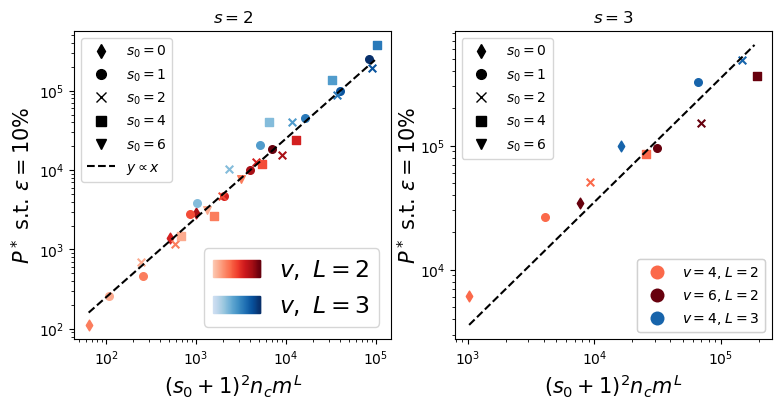

In [8]:
from matplotlib.legend_handler import HandlerTuple
import matplotlib.patches as patches


ns = ns = np.array([3,4,6,8,10,12])
s0s = [0,1,2,4,6]
    
Ls= [2,3]
sss = [2,3]
net = 'cnn2'
colors = cm.rainbow(np.linspace(0, 1, len(ns)))
#shades_of_red =  ['#8B0000', '#800000', '#B22222', '#DC143C', '#CD5C5C', '#F08080'][::-1]


cmap = plt.cm.get_cmap('Reds')

# Get the colorbar limits
vmin, vmax = 0.3, 1  # Assuming colorbar limits

# Sample k uniformly spaced points between vmin and vmax
sampled_values = np.linspace(vmin, vmax, 6)

# Convert sampled values to colors using the colormap
shades_of_red = [cmap(value) for value in sampled_values]


# Define shades of blue (from dark to light)
#shades_of_blue = ['#00008B', '#191970', '#000080', '#4169E1', '#1E90FF', '#87CEEB'][::-1]

cmap = plt.cm.get_cmap('Blues')

# Get the colorbar limits
vmin, vmax = 0.3, 1  # Assuming colorbar limits

# Sample k uniformly spaced points between vmin and vmax
sampled_values = np.linspace(vmin, vmax, 6)

# Convert sampled values to colors using the colormap
shades_of_blue = [cmap(value) for value in sampled_values]

colors = shades_of_red + shades_of_blue

cmap = plt.cm.get_cmap('Reds')

# Get the colorbar limits
vmin, vmax = 0.5, 1  # Assuming colorbar limits

# Sample k uniformly spaced points between vmin and vmax
sampled_values = np.linspace(vmin, vmax, 2)

# Convert sampled values to colors using the colormap
shades_of_red = [cmap(value) for value in sampled_values]


# Define shades of blue (from dark to light)
#shades_of_blue = ['#00008B', '#191970', '#000080', '#4169E1', '#1E90FF', '#87CEEB'][::-1]

cmap = plt.cm.get_cmap('Blues')

# Get the colorbar limits
vmin, vmax = 0.8, 1  # Assuming colorbar limits

# Sample k uniformly spaced points between vmin and vmax
sampled_values = np.linspace(vmin, vmax, 1)

# Convert sampled values to colors using the colormap
shades_of_blue = [cmap(value) for value in sampled_values]

colors_s3 = shades_of_red + shades_of_blue


fig, axs = plt.subplots(1,2, figsize = (9,4))





for (idx_s,s) in enumerate(sss):
    if s==2:
        idxx = 0
    elif s==3:
        idxx = 1
    #print('s: '+str(s))
    vs = []
    for (idx_L,L) in enumerate(Ls):
        #print('L: '+str(L))
        expo = 2
        if L==2:
            alpha = 1
            size = 30
        elif L==3:
            alpha = 1
            size =30
        

        for (idx_s0,s0) in enumerate(s0s):
            #print('s0: '+str(s0))

            if s0==0:
                mar = "d"
            elif s0==1:
                mar = "o"
            elif s0==2:
                mar = "x"
            elif s0==4:
                mar = "s"
            elif s0==6:
                mar = "v"
            for (idxn,n) in enumerate(ns):
                m = n**(s-1)
                col = colors[idxn+idx_L*len(ns)]
                if s==3:
                    if n==4 and L==2:
                        col = colors_s3[0]
                    if n==6 and L==2:
                        col = colors_s3[1]
                    if n==4 and L==3:
                        col = colors_s3[2]
                try:
                    
                    pstars = torch.load('pstars/pstars_task_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                    pstars = np.array(pstars)
                    
                    fact = 1#(s)**(L*.5)
                    expo =2
                    if pstars:
                        
                        if s0>0 and L==2 and s==2:
                            pstars = pstars
                        else:
                            pstars = pstars*n
                        axs[idxx].scatter([fact*((s0+1)**(expo))*n*m**(L)],[pstars],marker = mar,color = col, alpha = alpha,s = size)

                        #if L==3:
                        #    axs[idxx].scatter([fact*((s0+1)**(expo))*n*m**(L)],[pstars],marker = '+',color = 'black', alpha = alpha,s = size)
                        if s==4:
                            axs[idxx].scatter([fact*((s0+1)**(expo))*n*m**(L)],[pstars],marker = r'$s=4$',color = 'black', alpha = alpha,s = 1000)

                        vs+=[fact*(s0+1)**(expo)*n*m**(L)]
                        #print('ok')
                except:
                    pass
                
    min0 = min(vs)
    max0 = max(vs)
    print(min0,max0)
    ps = np.arange(min0,max0,(max0-min0)/20)
    C = max(pstars.flatten().tolist())/max0
    if idxx==0:
        axs[0].plot(ps,2.5*ps,color='black',ls='--')
    elif idxx ==1:
        axs[idxx].plot(ps,3.5*ps,color='black',ls='--')
    axs[idxx].set_title(r"$s= %d$" %(s))
    #axs[1].plot(ps,1*ps,label=r'$y=x$',color='black',ls='--')

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_yscale('log')

axs[0].set_xlabel(r'$(s_0+1)^{2} n_c m^{L}$',size = 15)
axs[1].set_xlabel(r'$(s_0+1)^{2} n_c m^{L}$',size = 15)
axs[0].set_ylabel(r'$P^*$ s.t. $\varepsilon = 10\%$',size = 15)
axs[1].set_ylabel(r'$P^*$ s.t. $\varepsilon = 10\%$',size = 15,labelpad =0)
#L3 = mlines.Line2D([], [], color='black', marker='+', linestyle='None',
#              markersize=7, label=r'$L=3$')

s00 = mlines.Line2D([], [], color='black', marker='d', linestyle='None',
              markersize=7, label=r'$s_0=0$')
s01 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
              markersize=7, label=r'$s_0=1$')
s02 = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
              markersize=7, label=r'$s_0=2$')
s03 = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
              markersize=7, label=r'$s_0=4$')
s04 = mlines.Line2D([], [], color='black', marker='v', linestyle='None',
              markersize=7, label=r'$s_0=6$')
s05 = mlines.Line2D([], [], color='black', linestyle='--',
              markersize=7, label=r'$y\propto x$')




#first_legend = axs[0].legend(fontsize = 8, loc='lower right')


ncmaps = 1     # number of colormaps to draw for illustration
ncolors = 100  # number high enough to draw a smooth gradient for each colormap

# Create random list of colormaps and extract list of colors to 
# draw the gradient of each colormap
cmaps_names = ['Reds', 'Blues'] #list(rng.choice(plt.colormaps(), size=ncmaps))
cmaps = [plt.cm.get_cmap(name) for name in cmaps_names]
cmaps_gradients = [cmap(np.linspace(0.2, 1, ncolors)) for cmap in cmaps]
cmaps_dict = dict(zip(cmaps_names, cmaps_gradients))

# Create a list of lists of patches representing the gradient of each colormap
patches_cmaps_gradients = []
for cmap_name, cmap_colors in cmaps_dict.items():
    cmap_gradient = [patches.Patch(facecolor=c, edgecolor=c, label=cmap_name)
                     for c in cmap_colors]
    patches_cmaps_gradients.append(cmap_gradient)

# Create custom legend (with a large fontsize to better illustrate the result)
first_legend = axs[0].legend(handles=patches_cmaps_gradients, labels=[r'$v,$ $L=2$', r'$v,$ $L=3$'], fontsize=17,
           handler_map={list: HandlerTuple(ndivide=None, pad=0)}, loc = 'lower right')





s2 = mlines.Line2D([], [], color='red', marker='o',  linestyle='None',
              markersize=9, label=r'$L=2$')
s3 = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
              markersize=9, label=r'$L=3$')
# Add s2 and s3 to the legend
axs[0].add_artist(first_legend)  # Re-add the first legend to the plot
#second_legend = axs[0].legend(handles=[s2, s3],  fontsize=15, loc= 'lower right', bbox_to_anchor=(1., 0.15))

#ax = axs[0].add_artist(second_legend)

#plt.legend(['Variable v'], handler_map={type(v): ColorGradientHandler()})

axs[0].legend(handles=[s00,s01,s02,s03,s04,s05],loc = 'upper left') 
leg1 = axs[1].legend(handles=[s00,s01,s02,s03,s04],loc = 'upper left') 

ax = axs[1].add_artist(leg1)

v0 = mlines.Line2D([], [], color=colors_s3[0], marker='o',  linestyle='None',
              markersize=9, label=r'$v=4$, $L=2$')
v1 = mlines.Line2D([], [], color=colors_s3[1], marker='o', linestyle='None',
              markersize=9, label=r'$v=6$, $L=2$')
v2 = mlines.Line2D([], [], color=colors_s3[2], marker='o', linestyle='None',
              markersize=9, label=r'$v=4$, $L=3$')

first_legend_2 = axs[1].legend(handles=[v0,v1,v2], fontsize=10,loc = 'lower right')
ax = axs[1].add_artist(first_legend_2)





plt.savefig("figures/pstar_task_cnn2_s0_L.png" , bbox_inches='tight')
plt.savefig("figures/pstar_task_cnn2_s0_L.pdf" , bbox_inches='tight')

[112.] [377632.]
[1.12000e+02 1.89880e+04 3.78640e+04 5.67400e+04 7.56160e+04 9.44920e+04
 1.13368e+05 1.32244e+05 1.51120e+05 1.69996e+05 1.88872e+05 2.07748e+05
 2.26624e+05 2.45500e+05 2.64376e+05 2.83252e+05 3.02128e+05 3.21004e+05
 3.39880e+05 3.58756e+05]
[256.] [377632.]
[2.56000000e+02 1.91248008e+04 3.79936016e+04 5.68624023e+04
 7.57312031e+04 9.46000039e+04 1.13468805e+05 1.32337605e+05
 1.51206406e+05 1.70075207e+05 1.88944008e+05 2.07812809e+05
 2.26681609e+05 2.45550410e+05 2.64419211e+05 2.83288012e+05
 3.02156812e+05 3.21025613e+05 3.39894414e+05 3.58763215e+05]
[6120.] [491520.]
[  6120.  30390.  54660.  78930. 103200. 127470. 151740. 176010. 200280.
 224550. 248820. 273090. 297360. 321630. 345900. 370170. 394440. 418710.
 442980. 467250.]
[26448.] [491520.]
[ 26448.         49701.6015625  72955.203125   96208.8046875
 119462.40625   142716.0078125 165969.609375  189223.2109375
 212476.8125    235730.4140625 258984.015625  282237.6171875
 305491.21875   328744.8203125 

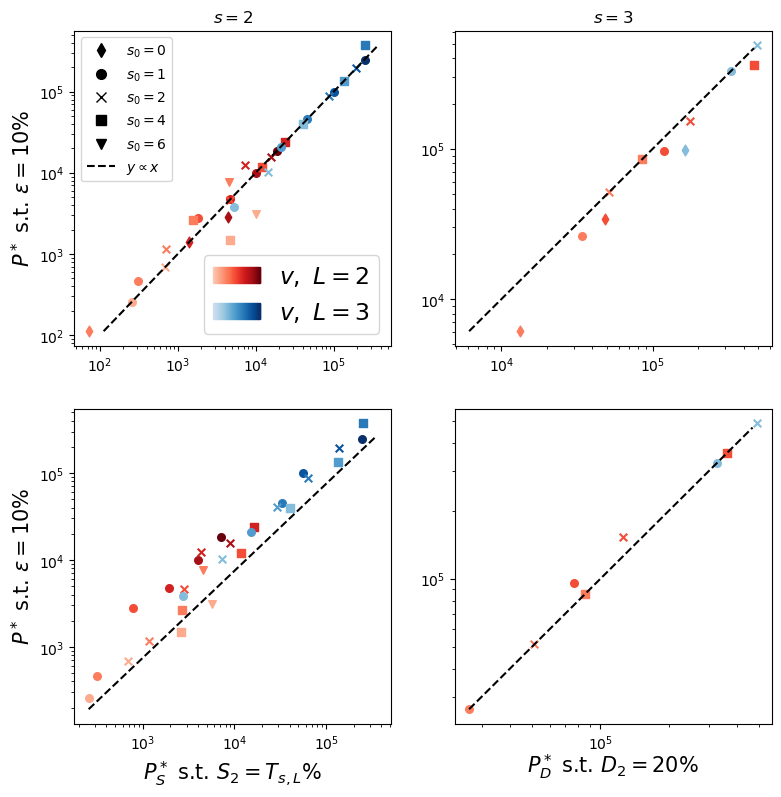

In [13]:
ns = ns = np.array([3,4,6,8,10,12])
s0s = [0,1,2,4,6]
    
Ls= [2,3]
sss = [2,3]
net = 'cnn2'
colors = cm.rainbow(np.linspace(0, 1, len(ns)))

cmap = plt.cm.get_cmap('Reds')

# Get the colorbar limits
vmin, vmax = 0.3, 1  # Assuming colorbar limits

# Sample k uniformly spaced points between vmin and vmax
sampled_values = np.linspace(vmin, vmax, 6)

# Convert sampled values to colors using the colormap
shades_of_red = [cmap(value) for value in sampled_values]


# Define shades of blue (from dark to light)
#shades_of_blue = ['#00008B', '#191970', '#000080', '#4169E1', '#1E90FF', '#87CEEB'][::-1]

cmap = plt.cm.get_cmap('Blues')

# Get the colorbar limits
vmin, vmax = 0.3, 1  # Assuming colorbar limits

# Sample k uniformly spaced points between vmin and vmax
sampled_values = np.linspace(vmin, vmax, 6)

# Convert sampled values to colors using the colormap
shades_of_blue = [cmap(value) for value in sampled_values]

colors = shades_of_red + shades_of_blue


fig, axs = plt.subplots(2,2, figsize = (9,9))



for (idx_s,s) in enumerate(sss):
    if s==2: idxx = 0
    if s==3: idxx = 1
        
    vs0 = []
    vs1 = []
    for (idx_L,L) in enumerate(Ls):
   
    
      
        if L==2:
            alpha = 1
            size = 30
        elif L==3:
            alpha = 1
            size =30

        for (idx_s0,s0) in enumerate(s0s):
           

            if s0==0:
                mar = "d"
            elif s0==1:
                mar = "o"
            elif s0==2:
                mar = "x"
            elif s0==4:
                mar = "s"
            elif s0==6:
                mar = "v"
            for (idxn,n) in enumerate(ns):
                m = n**(s-1)
                try:
                    pstars_task = torch.load('pstars/pstars_task_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                    pstars_pos = torch.load('pstars/pstars_pos_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                    pstars_sem = torch.load('pstars/pstars_sem_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt')  
                    pstars_task = np.array(pstars_task)
                    pstars_pos = np.array(pstars_pos)
                    pstars_sem = np.array(pstars_sem)
                    col = colors[idxn+idx_L*len(ns)]
                    
                    if pstars_task:
                        if s0>0 and L==2 and s==2:
                            pstars_task = pstars_task
                            pstars_sem = pstars_sem
                            pstars_pos = pstars_pos
                        else:
                            pstars_task = pstars_task*n
                            pstars_sem = pstars_sem*n
                            pstars_pos = pstars_pos*n
                        
                        #if idx_s0==1 and idx_L==0 and idx_s ==0:
                        #    axs[0,idxx].scatter([pstars_sem],[pstars_task],label = r'v: %d'%(n),marker = mar,color = col,s=size, alpha = alpha)
                        #    axs[1,idxx].scatter([pstars_pos],[pstars_task],marker = mar,color = col,s=size, alpha = alpha)

                        #else:
                        axs[0,idxx].scatter([pstars_sem],[pstars_task],marker = mar,color = col, alpha = alpha,s = size)
                        if s0>0:
                            axs[1,idxx].scatter([pstars_pos],[pstars_task],marker = mar,color = col, alpha = alpha,s = size)


                        vs0+=[pstars_task]
                        if s0>0:
                            vs1+=[pstars_task]
                        #print('ok')
                except:
                    pass
                
    min0 = min(vs0)
    max0 = max(vs0)
    print(min0,max0)
    ps = np.arange(min0,max0,(max0-min0)/20)
    print(ps)
    axs[0,idxx].plot(ps,1*ps,label=r'$y=x$',color='black',ls='--')
    min0 = min(vs1)
    max0 = max(vs1)
    print(min0,max0)
    ps = np.arange(min0,max0,(max0-min0)/20)
    print(ps)
    if s==2:
        axs[1,idxx].plot(ps,.75*ps,label=r'$y=x$',color='black',ls='--')
    else:
        axs[1,idxx].plot(ps,1*ps,label=r'$y=x$',color='black',ls='--')

axs[0,0].set_xscale('log')
axs[0,0].set_yscale('log')
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,1].set_xscale('log')
axs[1,1].set_yscale('log')

axs[0,0].set_ylabel(r'$P^*$ s.t. $\varepsilon = 10\%$',size = 15)
axs[1,0].set_ylabel(r'$P^*$ s.t. $\varepsilon = 10\%$',size = 15)
axs[1,0].set_xlabel(r'$P_S^*$ s.t. $S_{2} = T_{s,L} \%$',size = 15)
#axs[1,0].set_xlabel(r'$P_S^*$ s.t. $S_{2,1} = T_{s,L} \%$',size = 15)
# see above for threshod


#axs[1].set_xlabel(r'$P^*$ s.t. $\varepsilon = 10\%$',size = 15)
axs[1,1].set_xlabel(r'$P_D^*$ s.t. $D_{2} = 20\%$',size = 15,labelpad = -1)
#axs[0,1].set_ylabel(r'$P_D^*$ s.t. $D_{2,1} = 20\%$',size = 15,labelpad = -1)

s00 = mlines.Line2D([], [], color='black', marker='d', linestyle='None',
              markersize=7, label=r'$s_0=0$')
s01 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
              markersize=7, label=r'$s_0=1$')
s02 = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
              markersize=7, label=r'$s_0=2$')
s03 = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
              markersize=7, label=r'$s_0=4$')
s04 = mlines.Line2D([], [], color='black', marker='v', linestyle='None',
              markersize=7, label=r'$s_0=6$')
s05 = mlines.Line2D([], [], color='black', linestyle='--',
              markersize=7, label=r'$y\propto x$')

s2 = mlines.Line2D([], [], color='black', marker='o',  linestyle='None',
              markersize=3, label=r'$L=2$')
s3 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
              markersize=9, label=r'$L=3$')


first_legend = axs[0,0].legend(handles=[s00,s01,s02,s03,s04,s05],loc = 'upper left') 
ax = axs[0,0].add_artist(first_legend)
#second_legend = axs.legend()
axs[0,0].set_title(r"$s=2$")
#axs[0,1].set_title(r"$s=2$")

#axs[1,0].set_title(r"$s=3$")#,y=1.0,pad = -14)
axs[0,1].set_title(r"$s=3$")#,y=1.0,pad = -14)
#axs.legend(handles=[s2,s3],loc = 'lower left') 
#legend3 = axs.legend(loc='lower right')
#second_legend = axs.legend()

cmaps_names = ['Reds', 'Blues'] #list(rng.choice(plt.colormaps(), size=ncmaps))
cmaps = [plt.cm.get_cmap(name) for name in cmaps_names]
cmaps_gradients = [cmap(np.linspace(0.2, 1, ncolors)) for cmap in cmaps]
cmaps_dict = dict(zip(cmaps_names, cmaps_gradients))

# Create a list of lists of patches representing the gradient of each colormap
patches_cmaps_gradients = []
for cmap_name, cmap_colors in cmaps_dict.items():
    cmap_gradient = [patches.Patch(facecolor=c, edgecolor=c, label=cmap_name)
                     for c in cmap_colors]
    patches_cmaps_gradients.append(cmap_gradient)

# Create custom legend (with a large fontsize to better illustrate the result)
first_legend = axs[0,0].legend(handles=patches_cmaps_gradients, labels=[r'$v,$ $L=2$', r'$v,$ $L=3$'], fontsize=17,
           handler_map={list: HandlerTuple(ndivide=None, pad=0)}, loc = 'lower right')


#ax = axs.add_artist(second_legend)
plt.savefig("figures/pstar_sem_pos_cnn2_s0_L.png", bbox_inches='tight')
plt.savefig("figures/pstar_sem_pos_cnn2_s0_L.pdf" , bbox_inches='tight')

L: 2
s: 2
s0: 0
s0: 1
s0: 2
s0: 4
s0: 6
s: 3
s0: 0
s0: 1
s0: 2
s0: 4
s0: 6
s: 4
s0: 0
s0: 1
s0: 2
s0: 4
s0: 6
L: 3
s: 2
s0: 0
s0: 1
s0: 2
s0: 4
s0: 6
s: 3
s0: 0
s0: 1
s0: 2
s0: 4
s0: 6
s: 4
s0: 0
s0: 1
s0: 2
s0: 4
s0: 6
1 5


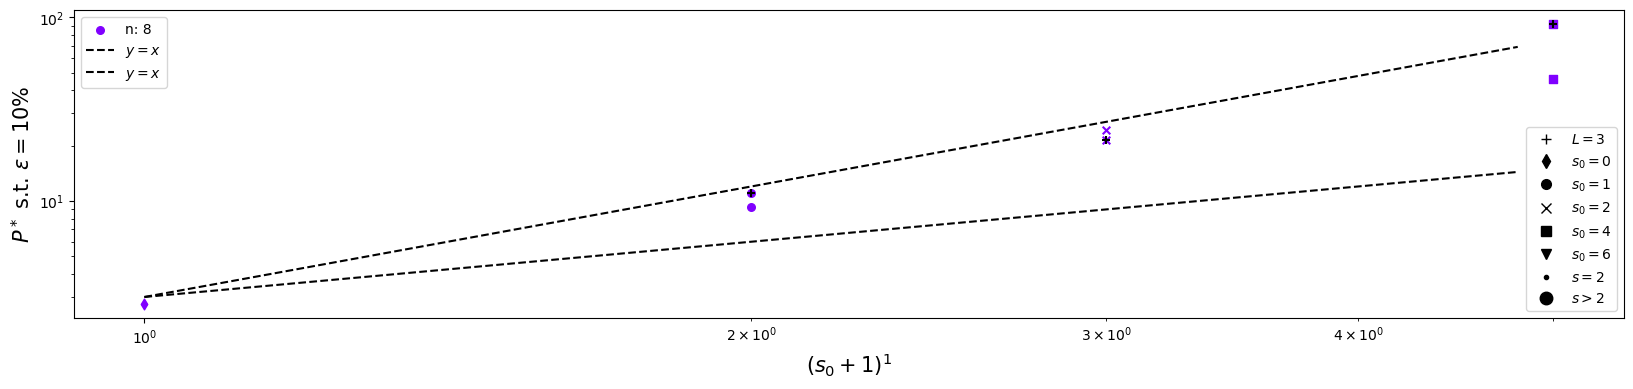

In [3]:
ns = ns = np.array([8])
s0s = [0,1,2,4,6]
    
Ls= [2,3]
sss = [2,3,4]
net = 'cnn2'
colors = cm.rainbow(np.linspace(0, 1, len(ns)))

fig, axs = plt.subplots(1,1, figsize = (20,4))

vs = []
vs2 = []

for (idx_L,L) in enumerate(Ls):
    print('L: '+str(L))
    for (idx_s,s) in enumerate(sss):
        print('s: '+str(s))
        if s==2:
            alpha = 1
            size = 30
        elif s==3:
            alpha = 1
            size =150
        elif s==4:
            alpha = 1
            size = 150

        for (idx_s0,s0) in enumerate(s0s):
            print('s0: '+str(s0))

            if s0==0:
                mar = "d"
            elif s0==1:
                mar = "o"
            elif s0==2:
                mar = "x"
            elif s0==4:
                mar = "s"
            elif s0==6:
                mar = "v"
            for (idxn,n) in enumerate(ns):
                m = n**(s-1)
                try:
                    pstars = torch.load('pstars/pstars_task_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt') 
                    pstars = np.array(pstars)
                    col = colors[idxn]
                    
                    if pstars:
                        if s0>0 and L==2 and s==2:
                            pstars = pstars
                        else:
                            pstars = pstars*n
                        facm = n*m**(L)
                        if idx_s0==1 and idx_L==0 and idx_s ==0:

                            
                            axs.scatter([((s0+1)**(1))],[pstars/facm],label = r'n: %d'%(n),marker = mar,color = col,s=size, alpha = alpha)
                        else:
                            axs.scatter([((s0+1)**(1))],[pstars/facm],marker = mar,color = col, alpha = alpha,s = size)

                        if L==3:
                            axs.scatter([((s0+1)**(1))],[pstars/facm],marker = '+',color = 'black', alpha = alpha,s = size)
                        if s==4:
                            axs.scatter([((s0+1)**(1))],[pstars/facm],marker = r'$s=4$',color = 'black', alpha = alpha,s = 1000)

                        vs+=[(s0+1)**(1)]
                        #print('ok')
                except:
                    pass
                
min0 = min(vs)
max0 = max(vs)
print(min0,max0)
ps = np.arange(min0,max0,(max0-min0)/20)
C = max(pstars.flatten().tolist())/max0
axs.plot(ps,3*ps,label=r'$y=x$',color='black',ls='--')

axs.plot(ps,3*ps**2,label=r'$y=x$',color='black',ls='--')


axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel(r'$(s_0+1)^{1} $',size = 15)
axs.set_ylabel(r'$P^*$ s.t. $\varepsilon = 10\%$',size = 15)
L3 = mlines.Line2D([], [], color='black', marker='+', linestyle='None',
              markersize=7, label=r'$L=3$')

s00 = mlines.Line2D([], [], color='black', marker='d', linestyle='None',
              markersize=7, label=r'$s_0=0$')
s01 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
              markersize=7, label=r'$s_0=1$')
s02 = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
              markersize=7, label=r'$s_0=2$')
s03 = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
              markersize=7, label=r'$s_0=4$')
s04 = mlines.Line2D([], [], color='black', marker='v', linestyle='None',
              markersize=7, label=r'$s_0=6$')

s2 = mlines.Line2D([], [], color='black', marker='o',  linestyle='None',
              markersize=3, label=r'$s=2$')
s3 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
              markersize=9, label=r'$s>2$')

first_legend = axs.legend()
ax = axs.add_artist(first_legend)

axs.legend(handles=[L3,s00,s01,s02,s03,s04,s2,s3],loc = 'lower right') 
#second_legend = axs.legend()
#axs.add_artist(second_legend)

#axs.legend(handles=[s2,s3],loc = 'lower left') 
#legend3 = axs.legend(loc='lower right')
#second_legend = axs.legend()
#ax = axs.add_artist(second_legend)
plt.savefig("figures/pstar_task_cnn_s01.png", bbox_inches='tight')
plt.savefig("figures/pstar_task_cnn_s01.pdf" , bbox_inches='tight')

L: 2
s: 2
s0: 0
s0: 1
s0: 2
s0: 4
s0: 6
s: 3
s0: 0
s0: 1
s0: 2
s0: 4
s0: 6
s: 4
s0: 0
s0: 1
s0: 2
s0: 4
s0: 6
L: 3
s: 2
s0: 0
s0: 1
s0: 2
s0: 4
s0: 6
s: 3
s0: 0
s0: 1


/home/tomasini/miniconda3/envs/condaenv/lib/python3.8/site-packages/numpy/ma/core.py:2820: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,


s0: 2
s0: 4
s0: 6
s: 4
s0: 0
s0: 1
s0: 2
s0: 4
s0: 6
64 2519424


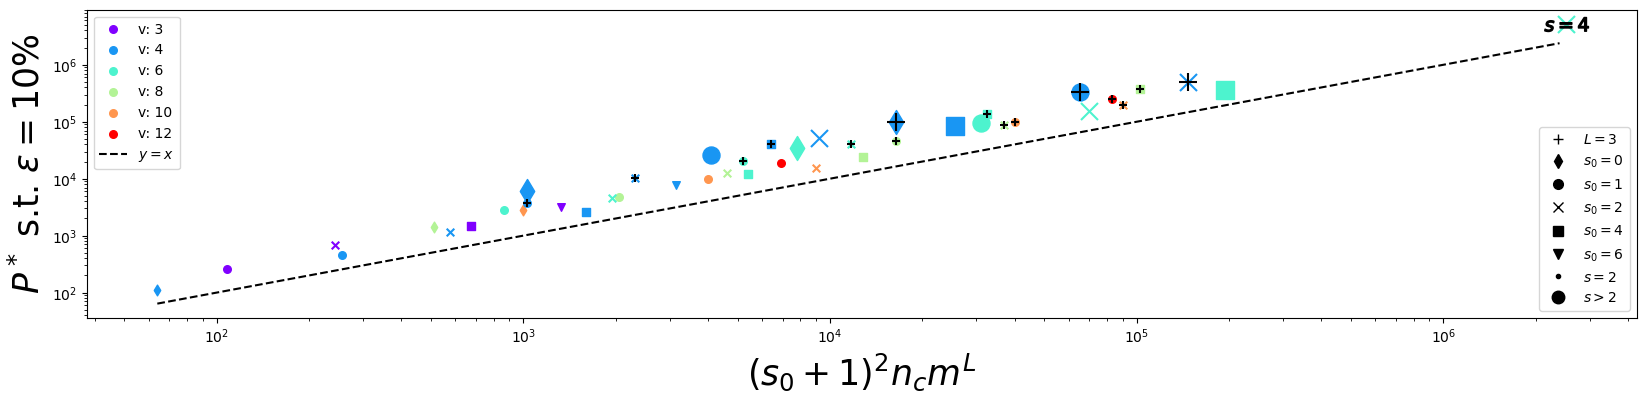

In [5]:
ns = ns = np.array([3,4,6,8,10,12])
s0s = [0,1,2,4,6]
    
Ls= [2,3]
sss = [2,3,4]
net = 'cnn2'
colors = cm.rainbow(np.linspace(0, 1, len(ns)))

fig, axs = plt.subplots(1,1, figsize = (20,4))

vs = []


for (idx_L,L) in enumerate(Ls):
    print('L: '+str(L))
    for (idx_s,s) in enumerate(sss):
        print('s: '+str(s))
        if s==2:
            alpha = 1
            size = 30
        elif s==3:
            alpha = 1
            size =150
        elif s==4:
            alpha = 1
            size = 150

        for (idx_s0,s0) in enumerate(s0s):
            print('s0: '+str(s0))

            if s0==0:
                mar = "d"
            elif s0==1:
                mar = "o"
            elif s0==2:
                mar = "x"
            elif s0==4:
                mar = "s"
            elif s0==6:
                mar = "v"
            for (idxn,n) in enumerate(ns):
                m = n**(s-1)
                try:
                    pstars = torch.load('pstars/pstars_task_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt') 
                    col = colors[idxn]
                    
                    if pstars:
                        if s0>0 and L==2 and s==2:
                            pstars = pstars
                        else:
                            pstars = pstars*n
                        facm = 1#n*m**(L)
                        facm0  = n*m**(L)
                        if idx_s0==1 and idx_L==0 and idx_s ==0:

                            
                            axs.scatter([facm0 *((s0+1)**(2))],[pstars/facm],label = r'v: %d'%(n),marker = mar,color = col,s=size, alpha = alpha)
                        else:
                            axs.scatter([facm0 *((s0+1)**(2))],[pstars/facm],marker = mar,color = col, alpha = alpha,s = size)

                        if L==3:
                            axs.scatter([facm0 *((s0+1)**(2))],[pstars/facm],marker = '+',color = 'black', alpha = alpha,s = size)
                        if s==4:
                            axs.scatter([facm0 *((s0+1)**(2))],[pstars/facm],marker = r'$s=4$',color = 'black', alpha = alpha,s = 1000)

                        vs+=[facm0 *(s0+1)**(2)]
                        #print('ok')
                except:
                    pass
                
min0 = min(vs)
max0 = max(vs)
print(min0,max0)
ps = np.arange(min0,max0,(max0-min0)/20)
C = max(pstars.flatten().tolist())/max0
axs.plot(ps,1*ps,label=r'$y=x$',color='black',ls='--')

axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel(r'$(s_0+1)^{2} n_c m^{L}$',size = 25)
axs.set_ylabel(r'$P^*$ s.t. $\varepsilon = 10\%$',size = 25)
L3 = mlines.Line2D([], [], color='black', marker='+', linestyle='None',
              markersize=7, label=r'$L=3$')

s00 = mlines.Line2D([], [], color='black', marker='d', linestyle='None',
              markersize=7, label=r'$s_0=0$')
s01 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
              markersize=7, label=r'$s_0=1$')
s02 = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
              markersize=7, label=r'$s_0=2$')
s03 = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
              markersize=7, label=r'$s_0=4$')
s04 = mlines.Line2D([], [], color='black', marker='v', linestyle='None',
              markersize=7, label=r'$s_0=6$')

s2 = mlines.Line2D([], [], color='black', marker='o',  linestyle='None',
              markersize=3, label=r'$s=2$')
s3 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
              markersize=9, label=r'$s>2$')

first_legend = axs.legend()
ax = axs.add_artist(first_legend)

axs.legend(handles=[L3,s00,s01,s02,s03,s04,s2,s3],loc = 'lower right') 
#second_legend = axs.legend()
#axs.add_artist(second_legend)

#axs.legend(handles=[s2,s3],loc = 'lower left') 
#legend3 = axs.legend(loc='lower right')
#second_legend = axs.legend()
#ax = axs.add_artist(second_legend)
plt.savefig("figures/pstar_task_cnn.png", bbox_inches='tight')
plt.savefig("figures/pstar_task_cnn.pdf" , bbox_inches='tight')

L: 2
s: 2
s0: 0
s0: 1
s0: 2
s0: 4
s0: 6
s: 3
s0: 0
s0: 1
s0: 2
s0: 4
s0: 6
s: 4
s0: 0
s0: 1
s0: 2
s0: 4
s0: 6
L: 3
s: 2
s0: 0
s0: 1
s0: 2
s0: 4
s0: 6
s: 3
s0: 0
s0: 1


/home/tomasini/miniconda3/envs/condaenv/lib/python3.8/site-packages/numpy/ma/core.py:2820: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,


s0: 2
s0: 4
s0: 6
s: 4
s0: 0
s0: 1
s0: 2
s0: 4
s0: 6
64 2519424


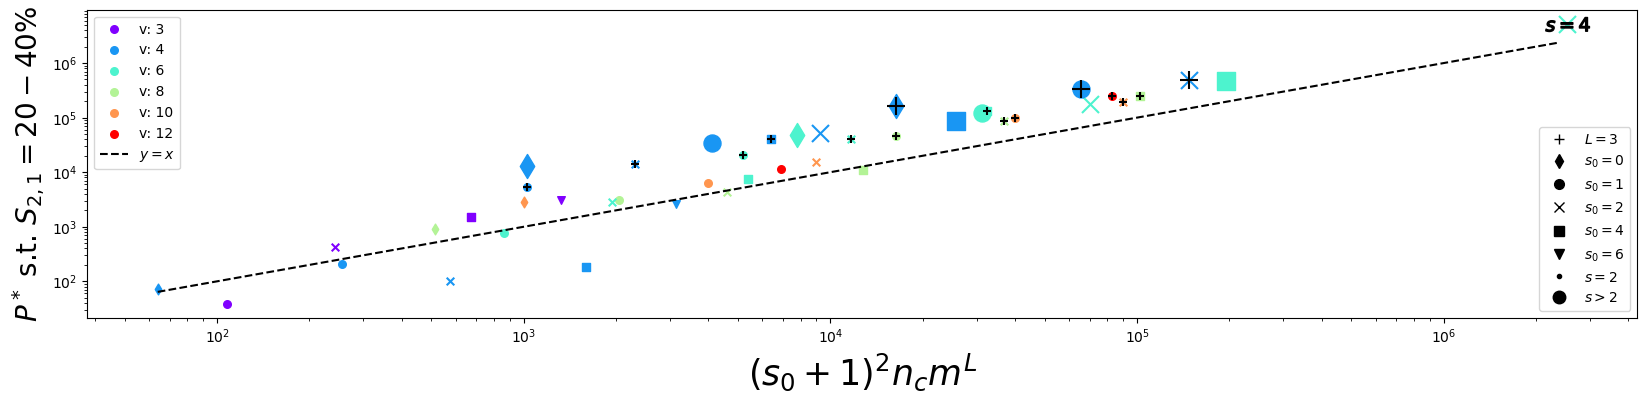

In [4]:
ns = ns = np.array([3,4,6,8,10,12])
s0s = [0,1,2,4,6]
    
Ls= [2,3]
sss = [2,3,4]
net = 'cnn2'
colors = cm.rainbow(np.linspace(0, 1, len(ns)))

fig, axs = plt.subplots(1,1, figsize = (20,4))

vs = []


for (idx_L,L) in enumerate(Ls):
    print('L: '+str(L))
    for (idx_s,s) in enumerate(sss):
        print('s: '+str(s))
        if s==2:
            alpha = 1
            size = 30
        elif s==3:
            alpha = 1
            size =150
        elif s==4:
            alpha = 1
            size = 150

        for (idx_s0,s0) in enumerate(s0s):
            print('s0: '+str(s0))

            if s0==0:
                mar = "d"
            elif s0==1:
                mar = "o"
            elif s0==2:
                mar = "x"
            elif s0==4:
                mar = "s"
            elif s0==6:
                mar = "v"
            for (idxn,n) in enumerate(ns):
                m = n**(s-1)
                try:
                    pstars = torch.load('pstars/pstars_sem_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt') 
                    col = colors[idxn]
                    
                    if pstars:
                        if s0>0 and L==2 and s==2:
                            pstars = pstars
                        else:
                            pstars = pstars*n
                        if idx_s0==1 and idx_L==0 and idx_s ==0:
                            axs.scatter([((s0+1)**(2))*n*m**(L)],[pstars],label = r'v: %d'%(n),marker = mar,color = col,s=size, alpha = alpha)
                        else:
                            axs.scatter([((s0+1)**(2))*n*m**(L)],[pstars],marker = mar,color = col, alpha = alpha,s = size)

                        if L==3:
                            axs.scatter([((s0+1)**(2))*n*m**(L)],[pstars],marker = '+',color = 'black', alpha = alpha,s = size)
                        if s==4:
                            axs.scatter([((s0+1)**(2))*n*m**(L)],[pstars],marker = r'$s=4$',color = 'black', alpha = alpha,s = 1000)

                        vs+=[(s0+1)**(2)*n*m**(L)]
                        #print('ok')
                except:
                    pass
                
min0 = min(vs)
max0 = max(vs)
print(min0,max0)
ps = np.arange(min0,max0,(max0-min0)/20)
C = max(pstars.flatten().tolist())/max0
axs.plot(ps,1*ps,label=r'$y=x$',color='black',ls='--')

axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel(r'$(s_0+1)^{2} n_c m^{L}$',size = 25)
axs.set_ylabel(r'$P^*$ s.t. $S_{2,1} = 20-40\%$',size = 20)
L3 = mlines.Line2D([], [], color='black', marker='+', linestyle='None',
              markersize=7, label=r'$L=3$')

s00 = mlines.Line2D([], [], color='black', marker='d', linestyle='None',
              markersize=7, label=r'$s_0=0$')
s01 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
              markersize=7, label=r'$s_0=1$')
s02 = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
              markersize=7, label=r'$s_0=2$')
s03 = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
              markersize=7, label=r'$s_0=4$')
s04 = mlines.Line2D([], [], color='black', marker='v', linestyle='None',
              markersize=7, label=r'$s_0=6$')

s2 = mlines.Line2D([], [], color='black', marker='o',  linestyle='None',
              markersize=3, label=r'$s=2$')
s3 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
              markersize=9, label=r'$s>2$')

first_legend = axs.legend()
ax = axs.add_artist(first_legend)

axs.legend(handles=[L3,s00,s01,s02,s03,s04,s2,s3],loc = 'lower right') 
#second_legend = axs.legend()
#axs.add_artist(second_legend)

#axs.legend(handles=[s2,s3],loc = 'lower left') 
#legend3 = axs.legend(loc='lower right')
#second_legend = axs.legend()
#ax = axs.add_artist(second_legend)
plt.savefig("figures/pstar_sem_cnn.png", bbox_inches='tight')
plt.savefig("figures/pstar_sem_cnn.pdf" , bbox_inches='tight')

/home/tomasini/miniconda3/envs/condaenv/lib/python3.8/site-packages/numpy/ma/core.py:2820: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,


tensor([2744.])
108 2519424


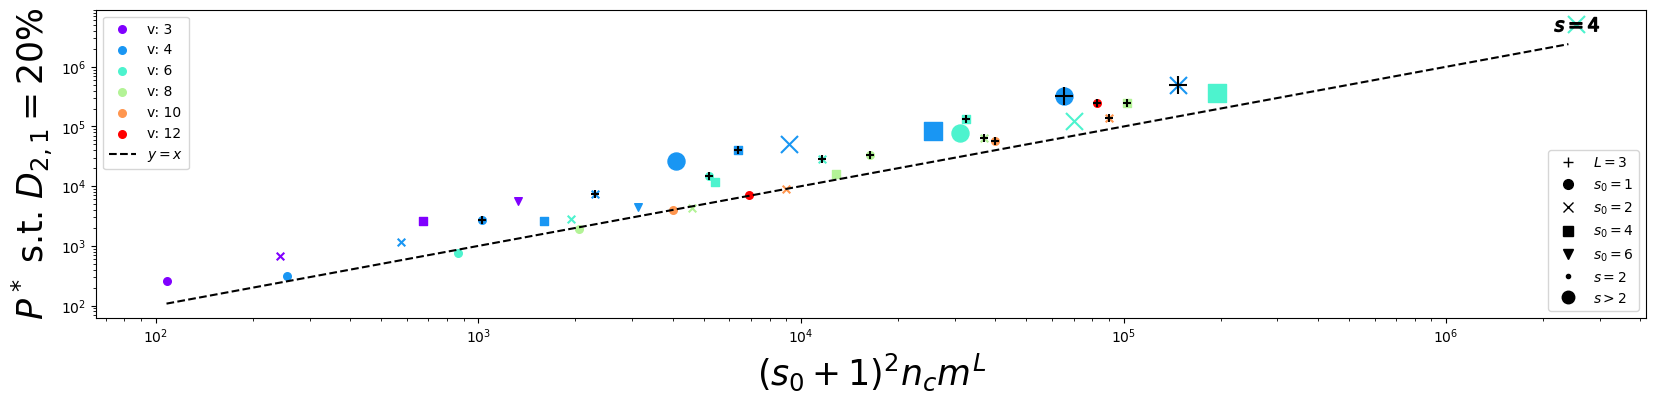

In [3]:
ns = ns = np.array([3,4,6,8,10,12])
s0s = [1,2,4,6]
    
Ls= [2,3]
sss = [2,3,4]
net = 'cnn2'
colors = cm.rainbow(np.linspace(0, 1, len(ns)))

fig, axs = plt.subplots(1,1, figsize = (20,4))

vs = []


for (idx_L,L) in enumerate(Ls):
    #print('L: '+str(L))
    for (idx_s,s) in enumerate(sss):
        #print('s: '+str(s))
        if s==2:
            alpha = 1
            size = 30
        elif s==3:
            alpha = 1
            size =150
        elif s==4:
            alpha = 1
            size = 150

        for (idx_s0,s0) in enumerate(s0s):
            #print('s0: '+str(s0))

            if s0==0:
                mar = "d"
            elif s0==1:
                mar = "o"
            elif s0==2:
                mar = "x"
            elif s0==4:
                mar = "s"
            elif s0==6:
                mar = "v"
            for (idxn,n) in enumerate(ns):
                m = n**(s-1)
                try:
                    pstars = torch.load('pstars/pstars_pos_'+net+'_L_'+str(L)+'_n_'+str(n)+'_m_'+str(m)+'_s_'+str(s)+'_s0_'+str(s0)+'.pt') 
                    #print(pstars)
                    col = colors[idxn]
                    
                    if pstars:
                        if s0>0 and L==2 and s==2:
                            pstars = pstars
                        else:
                            pstars = pstars*n
                        if idx_s0==0 and idx_L==0 and idx_s ==0:
                            axs.scatter([((s0+1)**(2))*n*m**(L)],[pstars],label = r'v: %d'%(n),marker = mar,color = col,s=size, alpha = alpha)
                        else:
                            axs.scatter([((s0+1)**(2))*n*m**(L)],[pstars],marker = mar,color = col, alpha = alpha,s = size)

                        if L==3:
                            axs.scatter([((s0+1)**(2))*n*m**(L)],[pstars],marker = '+',color = 'black', alpha = alpha,s = size)
                        if s==4:
                            axs.scatter([((s0+1)**(2))*n*m**(L)],[pstars],marker = r'$s=4$',color = 'black', alpha = alpha,s = 1000)

                        vs+=[(s0+1)**(2)*n*m**(L)]
                        #print('ok')
                        if L==3 and s0==1 and s==2 and n==4:
                            print(pstars)
                except:
                    pass
                
min0 = min(vs)
max0 = max(vs)
print(min0,max0)
ps = np.arange(min0,max0,(max0-min0)/20)
C = max(pstars.flatten().tolist())/max0
axs.plot(ps,1*ps,label=r'$y=x$',color='black',ls='--')

axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlabel(r'$(s_0+1)^{2} n_c m^{L}$',size = 25)
axs.set_ylabel(r'$P^*$ s.t. $D_{2,1} = 20\%$',size = 25)
L3 = mlines.Line2D([], [], color='black', marker='+', linestyle='None',
              markersize=7, label=r'$L=3$')

s00 = mlines.Line2D([], [], color='black', marker='d', linestyle='None',
              markersize=7, label=r'$s_0=0$')
s01 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
              markersize=7, label=r'$s_0=1$')
s02 = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
              markersize=7, label=r'$s_0=2$')
s03 = mlines.Line2D([], [], color='black', marker='s', linestyle='None',
              markersize=7, label=r'$s_0=4$')
s04 = mlines.Line2D([], [], color='black', marker='v', linestyle='None',
              markersize=7, label=r'$s_0=6$')

s2 = mlines.Line2D([], [], color='black', marker='o',  linestyle='None',
              markersize=3, label=r'$s=2$')
s3 = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
              markersize=9, label=r'$s>2$')

first_legend = axs.legend()
ax = axs.add_artist(first_legend)

axs.legend(handles=[L3,s01,s02,s03,s04,s2,s3],loc = 'lower right') 
#second_legend = axs.legend()
#axs.add_artist(second_legend)

#axs.legend(handles=[s2,s3],loc = 'lower left') 
#legend3 = axs.legend(loc='lower right')
#second_legend = axs.legend()
#ax = axs.add_artist(second_legend)
plt.savefig("figures/pstar_pos_cnn.png", bbox_inches='tight')
plt.savefig("figures/pstar_pos_cnn.pdf" , bbox_inches='tight')